In [24]:
# %pip install rdkit-pypi
import rdkit as rd
from rdkit import Chem
from rdkit.Chem import AllChem
import pubchempy as pcp

import unittest
import numpy as np
import matplotlib.pyplot as plt
import moleculegraph
from moleculegraph.molecule_utils import *
import networkx as nx

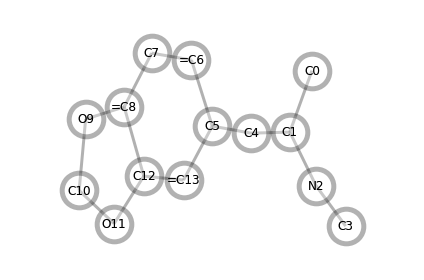

[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]


In [2]:
def get_graphstring(bond_list, names):
    graph = graph_from_bonds(bond_list)
    idx = 0

    main_path  = get_longest_path(graph,source=idx)

    return get_graphstring_set_main( graph, bond_list, names, main_path)

def make_graph( stringlist ):
    """
    builds graph string from string list
    Args:
        stringlist:
            - list of strings containing names and 
            - add file format at the end ;)
    Returns:
        nothing        
    """        
    return "["+"][".join(stringlist)+"]"

def get_bond_types( atom_names, bond_list , special_bond_types=["="] ):
    atom_bond_types = np.array( [""]*len(atom_names) )
    clean_atom_names = atom_names.copy()
    for i,atom_name in enumerate(atom_names):
        for special_bond_type in special_bond_types:
            if special_bond_type in atom_name:
                clean_atom_names[i] = atom_name.replace(special_bond_type,"")
                atom_bond_types[i]  = special_bond_type
    bond_types = np.array( [""]*len( bond_list) )
    for i in np.squeeze( np.where( atom_bond_types != "" ) ):
        loc = np.max(np.where( i == np.squeeze(bond_list[:,1])  ) )
        bond_types[loc] = atom_bond_types[i]                
                
    return clean_atom_names, bond_types

def get_graphstring_set_main(graph, bond_list, names, main_path, 
                             bond_types=[] ):
    """
    generates a graphstring from a bond list and atom names
    uses the longest path from source to an end as main path
    
    Args:  
        graph:
            - networkx graph object  
        bond_list: 
            - np.array, bond list           
        names: 
            - np.array, atom names   
        main_path: 
            - np.array, main path to build graph from               
    Returns:
        str, graphstring to use with moleculegraph          
    """
    funs       = np.zeros(main_path.shape)
    fun_ranges = np.zeros(main_path.shape)

    main_path_bond_list = bond_list_from_simple_path(main_path)
    remaining_bonds     = get_diff_in_bond_lists(bond_list, main_path_bond_list)

    if remaining_bonds.size > 0:
        while True:
            subgraph = graph_from_bonds(remaining_bonds)

            idx = get_next_index(main_path,remaining_bonds)

            subpath = get_longest_path(subgraph, source=idx)
            subpath_bond_list = bond_list_from_simple_path(subpath)
            match = np.intersect1d(main_path, subpath)

            if len(match)==2 and len(subpath)==2:
                print("ring")
                subpath = get_shortest_nontrivial_path(graph,match[0], match[1])
                i = np.squeeze( np.where(main_path == match[0]) )
                j = np.squeeze( np.where(main_path == match[1]) )
                iinsert = np.max( (i,j) )+1

                main_path  = np.insert( main_path, iinsert, [-1] )
                fun_ranges = np.insert( fun_ranges, iinsert, [len(subpath)] )
                funs       = np.insert( funs, iinsert, [-1] )        

            elif len(match)==1:
                print("branch")
                i = np.squeeze(match)
                if subpath[0] != i:
                    subpath = subpath[::-1]
                subpath = subpath[1:]

                subfuns       = np.concatenate( [ [1], np.zeros(subpath.shape) ])
                subfun_ranges = np.concatenate( [ [len(subpath)], np.zeros(subpath.shape)  ])      
                subpath       = np.concatenate( [ [-1], subpath ])  

                iinsert = np.squeeze( np.where(main_path == i) )+1

                main_path  = np.insert( main_path, iinsert, subpath )
                fun_ranges = np.insert( fun_ranges, iinsert, subfun_ranges )
                funs       = np.insert( funs, iinsert, subfuns )

            else:
                print("ERROR")
                return None, None

            main_path_bond_list = np.concatenate( [main_path_bond_list, subpath_bond_list] )    
            remaining_bonds     = get_diff_in_bond_lists(bond_list, main_path_bond_list)
            if len(remaining_bonds) == 0:
                break
    
    if "".join(bond_types) == "dff":
        dummy = main_path_bond_list.flatten()
        _, idx = np.unique( dummy, return_index=True)
        atom_nos = dummy[np.sort(idx)]        
        atom_names = names[atom_nos]
        for bond, bond_type in zip( bond_list, bond_types):
            p0 = np.squeeze( np.where( atom_nos==bond[0] ) )
            p1 = np.squeeze( np.where( atom_nos==bond[1] ) )
            dummy = [p0,p1]
            pp  = bond[ np.argmax( dummy ) ]
 
            names[pp] = bond_type+names[pp]
    
    molecule_list = []
    for i, (fun,rang) in zip( main_path, zip( funs, fun_ranges ) ):
        if fun == 0:
            molecule_list.append( names[i] )
        elif fun == 1:
            molecule_list.append( "b"+str( int(rang) ) ) 
        elif fun == -1:
            molecule_list.append( "r"+str( int(rang) ) )    

    molstring = "["+ "][".join(molecule_list) +"]"        
                    
    return molstring, main_path_bond_list



molstring = "[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]"

molecule = moleculegraph.molecule(molstring)
molecule.visualize()
print(molstring)

In [3]:
ends = np.concatenate( [molecule.branch_end_numbers, molecule.ring_close_numbers, molecule.ring_root_numbers] ).astype(int)


0 C0
branch
ring
ring
[C0][C1][b2][N2][C3][C4][C5][C13][C12][O11][C10][O9][C8][r5][C7][C6][r6]


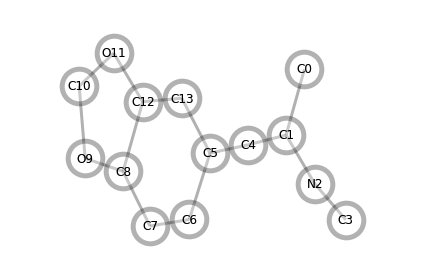

NEXT


3 C3
branch
ring
ring
[C3][N2][C1][b1][C0][C4][C5][C13][C12][O11][C10][O9][C8][r5][C7][C6][r6]


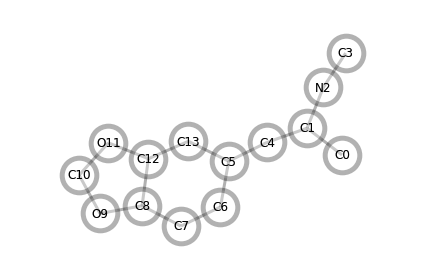

NEXT


12 C12
ERROR
NEXT


13 =C13
ring
branch
ring
[C13][C12][O11][C10][O9][C8][r5][C7][C6][C5][r6][C4][C1][b1][C0][N2][C3]


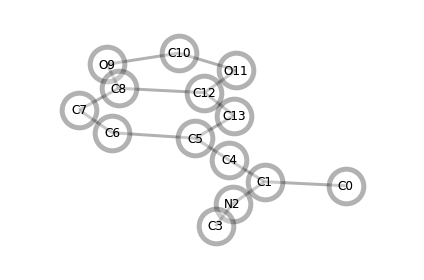

NEXT


8 =C8
ERROR
NEXT


5 C5
ring
branch
ring
branch
[C5][b4][C4][C1][b1][C0][N2][C3][C13][C12][O11][C10][O9][C8][r5][C7][C6][r6]


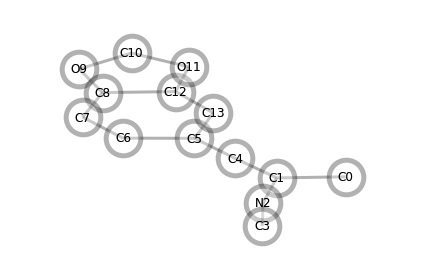

NEXT




In [4]:
"""

=C6, C5: branch close on start should not work

"""

graph = graph_from_bonds(molecule.bond_list)
for end in ends:
    print(end, molecule.atom_names[end])
    main_path_dummy  = get_longest_path(graph,source=end)
    clean_atom_names, bond_types = get_bond_types( molecule.atom_names, molecule.bond_list, special_bond_types=["="]  )
    molstring_dummy, main_path_bond_list = get_graphstring_set_main(graph, molecule.bond_list, clean_atom_names, 
                                               main_path_dummy, bond_types)
    if molstring_dummy:
        print(molstring_dummy)
        molecule_dummy = moleculegraph.molecule(molstring_dummy)
        molecule_dummy.visualize()
    print("NEXT\n\n")

In [5]:
clean_atom_names, molecule.atom_names

(array(['C0', 'C1', 'N2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'O9', 'C10',
        'O11', 'C12', 'C13'], dtype='<U4'),
 array(['C0', 'C1', 'N2', 'C3', 'C4', 'C5', '=C6', 'C7', '=C8', 'O9',
        'C10', 'O11', 'C12', '=C13'], dtype='<U4'))

In [6]:
"=C6".replace("=","")

'C6'

In [7]:
def get_syntax_from_numbers(mol_array, 
                            branch_operators=["b"], 
                            ring_operators=["r"]):
    """
    - gets syntactic elemnts from a splitted molstring
    - rings and brances are marked with letters followed
      by a number giving the size
    """
    n=0
    ff = np.zeros(len(mol_array))
    nn = -1 * np.ones(len(mol_array))
    for i,m in enumerate( mol_array ):
        if re.sub(r"\d+","", m) in branch_operators:
            ff[i] = int(re.sub("[^0-9]","", m ))
        elif re.sub(r"\d+","", m) in ring_operators:
            ff[i] = -int(re.sub("[^0-9]","", m ))
        else:
            nn[i] = n
            n+=1
    return ff.astype(int) ,nn.astype(int)

In [8]:
class moleculegraph_syntax():

    def __init__(self,
                 split="][",
                 start="[", end="]",
                 branch_operator="b",
                 ring_operator="r"
                ):
        self.split = split
        self.start = start
        self.end   = end
        self.branch_operator = branch_operator
        self.ring_operator = ring_operator
        return
    
    def get_from_string(self, molstring):
        mol_array = self.splitter(molstring)
        return self.get_from_array(mol_array)
        
        
    def get_from_array(self, mol_array):
        """
        - gets syntactic elemnts from a splitted molstring
        - rings and brances are marked with letters followed
          by a number giving the size
        """
        n=0
        ff = np.zeros(len(mol_array))
        nn = -1 * np.ones(len(mol_array))
        for i,m in enumerate( mol_array ):
            if re.sub(r"\d+","", m) == self.branch_operator:
                ff[i] = int(re.sub("[^0-9]","", m ))
            elif re.sub(r"\d+","", m) == self.ring_operator:
                ff[i] = -int(re.sub("[^0-9]","", m ))
            else:
                nn[i] = n
                n+=1
        return ff.astype(int) ,nn.astype(int)        
        
    #def build_string_array(self, molecule):
    def build_string_array(self, atom_names, funs):
        def builder(x):
            if x > 0:
                x = self.branch_operator + str( int(np.abs(x)) )
            elif x < 0:
                x = self.ring_operator + str( int(np.abs(x)) )
            return x
        #dummy = molecule.f.copy().astype(str)
        dummy = funs.copy().astype(str)
        dummy[ funs==0 ] = atom_names #molecule.atom_names
        #dummy[ molecule.f!=0]  = np.vectorize(builder)( molecule.f[ molecule.f!=0] )
        dummy[ funs!=0]  = np.vectorize(builder)( funs[ funs!=0] )
        return dummy
        
    #def build_string(self,molecule):
    def build_string(self, atom_names, funs):
        mol_array = self.build_string_array( atom_names, funs)
        return self.stringer( mol_array )
    
    def splitter(self, molstring):
        a = len(self.start)
        b = len(self.end)
        return np.array(molstring[a:-b].split(self.split))
        
    def stringer(self, mol_array ):
        return self.start+ self.split.join(mol_array) + self.end 

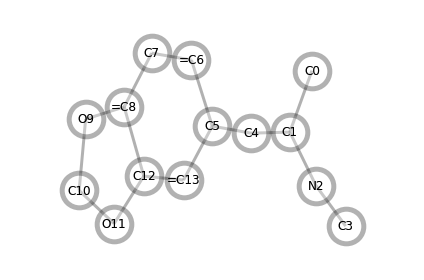

In [9]:
molstring = "[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]"
molstring = "[C0][C1][xx2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][yy5][=C13][yy6]"

syn = moleculegraph_syntax(branch_operator="xx",ring_operator="yy")

molecule = moleculegraph.molecule(molstring, splitter=syn.splitter, get_syntax=syn.get_from_array)

molecule.visualize() 

In [10]:
molecule.branch_end_indexes, molecule.branch_end_numbers

(array([0, 4]), array([0, 3]))

In [11]:
molecule.atom_names

array(['C0', 'C1', 'N2', 'C3', 'C4', 'C5', '=C6', 'C7', '=C8', 'O9',
       'C10', 'O11', 'C12', '=C13'], dtype='<U4')

In [12]:
molecule.f==0

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False])

In [13]:
dummy = molecule.f.copy()

dummy

array([ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -5,  0, -6])

In [14]:
def builder(x):
    if x > 0:
        x = "b" +  str(np.abs(x) )
    elif x < 0:
        x = "r" + str(np.abs(x) )
    return x


dummy = molecule.f.copy().astype(str)
dummy[ molecule.f==0 ] = molecule.atom_names
dummy[ molecule.f!=0]  = np.vectorize(builder)( molecule.f[ molecule.f!=0] )

dummy

array(['C0', 'C1', 'b2', 'N2', 'C3', 'C4', 'C5', '=C6', 'C7', '=C8', 'O9',
       'C10', 'O11', 'C12', 'r5', '=C13', 'r6'], dtype='<U21')

In [15]:
molecule.f

array([ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -5,  0, -6])

In [16]:
class SMILES_syntax():

    def __init__(self,
                 split="][",
                 start="[", end="]",
                 branch_operator="b",
                 ring_operator="r"
                ):
        self.split = split
        self.start = start
        self.end   = end
        self.branch_operator = branch_operator
        self.ring_operator = ring_operator
        return
    
    def get_from_string(self, molstring):
        mol_array = self.splitter(molstring)
        return self.get_from_array(mol_array)
        
        
    def get_from_array(self, mol_array):
        """
        - gets syntactic elemnts from a splitted molstring
        - rings and brances are marked with letters followed
          by a number giving the size
        """
        n=0
        ff = np.zeros(len(mol_array))
        nn = -1 * np.ones(len(mol_array))
        for i,m in enumerate( mol_array ):
            if re.sub(r"\d+","", m) == self.branch_operator:
                ff[i] = int(re.sub("[^0-9]","", m ))
            elif re.sub(r"\d+","", m) == self.ring_operator:
                ff[i] = -int(re.sub("[^0-9]","", m ))
            else:
                nn[i] = n
                n+=1
        return ff.astype(int) ,nn.astype(int)        
        
    def build_string_array(self, molecule):
        def builder(x):
            if x > 0:
                x = self.branch_operator + str( np.abs(x) )
            elif x < 0:
                x = self.ring_operator + str( np.abs(x) )
            return x
        dummy = molecule.f.copy().astype(str)
        dummy[ molecule.f==0 ] = molecule.atom_names
        dummy[ molecule.f!=0]  = np.vectorize(builder)( molecule.f[ molecule.f!=0] )
        return dummy
        
    def build_string(self,molecule):
        mol_array = self.build_string_array(molecule)
        return 
    
    def splitter(self, molstring):
        a = len(self.start)
        b = len(self.end)
        return np.array(molstring[a:-b].split(self.split))
        
    def stringer(self, mol_array ):
        return self.start+ self.split.join(molecule_list) + self.end 

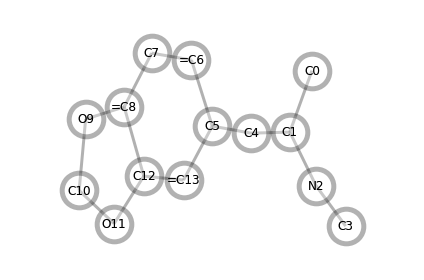

branch
ring
ring
[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]


In [17]:
   
def get_graphstring(bond_list, names):
    graph = graph_from_bonds(bond_list)
    idx = 0

    main_path  = get_longest_path(graph,source=idx)

    return get_graphstring_set_main( graph, bond_list, names, main_path)

def make_graph( stringlist ):
    """
    builds graph string from string list
    Args:
        stringlist:
            - list of strings containing names and 
            - add file format at the end ;)
    Returns:
        nothing        
    """        
    return "["+"][".join(stringlist)+"]"

def get_bond_types( atom_names, bond_list , special_bond_types=["="] ):
    atom_bond_types = np.array( [""]*len(atom_names) )
    clean_atom_names = atom_names.copy()
    for i,atom_name in enumerate(atom_names):
        for special_bond_type in special_bond_types:
            if special_bond_type in atom_name:
                clean_atom_names[i] = atom_name.replace(special_bond_type,"")
                atom_bond_types[i]  = special_bond_type
    bond_types = np.array( [""]*len( bond_list) )
    for i in np.squeeze( np.where( atom_bond_types != "" ) ):
        loc = np.max(np.where( i == np.squeeze(bond_list[:,1])  ) )
        bond_types[loc] = atom_bond_types[i]                
                
    return clean_atom_names, bond_types

def get_fun_arrays_set_main(graph, bond_list, names, main_path, 
                             bond_types=[] ):
    """
    generates a graphstring from a bond list and atom names
    uses the longest path from source to an end as main path
    
    Args:  
        graph:
            - networkx graph object  
        bond_list: 
            - np.array, bond list           
        names: 
            - np.array, atom names   
        main_path: 
            - np.array, main path to build graph from               
    Returns:
        str, graphstring to use with moleculegraph          
    """
    funs       = np.zeros(main_path.shape)
    fun_ranges = np.zeros(main_path.shape)

    main_path_bond_list = bond_list_from_simple_path(main_path)
    remaining_bonds     = get_diff_in_bond_lists(bond_list, main_path_bond_list)

    if remaining_bonds.size > 0:
        while True:
            subgraph = graph_from_bonds(remaining_bonds)

            idx = get_next_index(main_path,remaining_bonds)

            subpath = get_longest_path(subgraph, source=idx)
            subpath_bond_list = bond_list_from_simple_path(subpath)
            match = np.intersect1d(main_path, subpath)

            if len(match)==2 and len(subpath)==2:
                print("ring")
                subpath = get_shortest_nontrivial_path(graph,match[0], match[1])
                i = np.squeeze( np.where(main_path == match[0]) )
                j = np.squeeze( np.where(main_path == match[1]) )
                iinsert = np.max( (i,j) )+1

                main_path  = np.insert( main_path, iinsert, [-1] )
                fun_ranges = np.insert( fun_ranges, iinsert, [len(subpath)] )
                funs       = np.insert( funs, iinsert, [-1] )        

            elif len(match)==1:
                print("branch")
                i = np.squeeze(match)
                if subpath[0] != i:
                    subpath = subpath[::-1]
                subpath = subpath[1:]

                subfuns       = np.concatenate( [ [1], np.zeros(subpath.shape) ])
                subfun_ranges = np.concatenate( [ [len(subpath)], np.zeros(subpath.shape)  ])      
                subpath       = np.concatenate( [ [-1], subpath ])  

                iinsert = np.squeeze( np.where(main_path == i) )+1

                main_path  = np.insert( main_path, iinsert, subpath )
                fun_ranges = np.insert( fun_ranges, iinsert, subfun_ranges )
                funs       = np.insert( funs, iinsert, subfuns )

            else:
                print("ERROR")
                return None, None

            main_path_bond_list = np.concatenate( [main_path_bond_list, subpath_bond_list] )    
            remaining_bonds     = get_diff_in_bond_lists(bond_list, main_path_bond_list)
            if len(remaining_bonds) == 0:
                break
    
    return funs*fun_ranges, main_path
    #return molstring, main_path_bond_list



molstring = "[C0][C1][b2][N2][C3][C4][C5][=C6][C7][=C8][O9][C10][O11][C12][r5][=C13][r6]"

molecule = moleculegraph.molecule(molstring)
molecule.visualize()
    
graph = graph_from_bonds(molecule.bond_list)
idx = 0

main_path  = get_longest_path(graph,source=idx)

a,b = get_fun_arrays_set_main( graph, molecule.bond_list, molecule.atom_names, main_path)

print(molstring) 


In [18]:
a,b

(array([ 0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        -5.,  0.,  0., -6.]),
 array([ 0,  1, -1,  2,  3,  4,  5, 13, 12, 11, 10,  9,  8, -1,  7,  6, -1]))

In [19]:
molecule.atom_names

array(['C0', 'C1', 'N2', 'C3', 'C4', 'C5', '=C6', 'C7', '=C8', 'O9',
       'C10', 'O11', 'C12', '=C13'], dtype='<U4')

In [20]:
aatom_names = molecule.atom_names[ b[ b>=0 ] ]

aatom_names

array(['C0', 'C1', 'N2', 'C3', 'C4', 'C5', '=C13', 'C12', 'O11', 'C10',
       'O9', '=C8', 'C7', '=C6'], dtype='<U4')

In [21]:
ms = moleculegraph_syntax().build_string(aatom_names,a)
ms

'[C0][C1][b2][N2][C3][C4][C5][=C13][C12][O11][C10][O9][=C8][r5][C7][=C6][r6]'

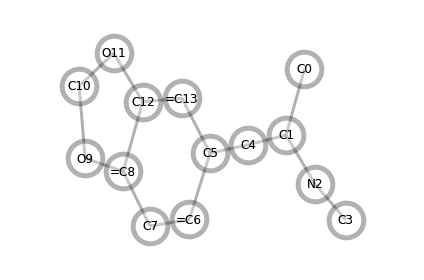

In [22]:
xx = moleculegraph.molecule(ms)

xx.visualize()

branch


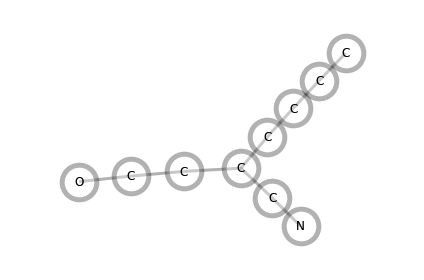

'[C][C][C][C][C][b2][C][N][C][C][O]'

In [23]:
smile = "CCCCC(CCO)CN"
#smile = "Cc1c([N+]([O-])=O)cc([N+]([O-])=O)cc1[N+]([O-])=O"
mol = Chem.MolFromSmiles(smile)

atoms = []
atom_names = []
for a in mol.GetAtoms():
    atoms.append(a.GetIdx())
    atom_names.append( a.GetSymbol() )
    
bonds = []
for bond in mol.GetBonds():
    aid1 = atoms[bond.GetBeginAtomIdx()]
    aid2 = atoms[bond.GetEndAtomIdx()]
    bonds.append( np.array( [aid1,aid2] ) )

atoms      = np.array(atoms)
atom_names = np.array(atom_names)
bonds = np.array( bonds )

graph = graph_from_bonds( bonds )
idx = 0

main_path  = get_longest_path(graph,source=idx)

a,b = get_fun_arrays_set_main( graph, bonds, atom_names, main_path)

aatom_names = atom_names[ b[ b>=0 ] ]

ms = moleculegraph_syntax().build_string(aatom_names,a)

xx = moleculegraph.molecule(ms)

xx.visualize()
ms

In [25]:
pcp.get_compounds('Aspirin', 'name', record_type='3d')

[Compound(2244)]

In [33]:
#Get pubmol via Pupchem
smile = "CCC(CCCO)CCC"
pubmol = pcp.get_compounds(smile, "smiles", record_type='3d')[0]

atoms_xyz = []
atom_names = []
for a in pubmol.atoms:
    atoms_xyz.append( [a.x,a.y,a.z]) #coordinates for pubmol
    atom_names.append(a.element) #atom name

bond_list = []
for bond in pubmol.bonds:
    bond_list.append( [bond.aid1,bond.aid2] ) #Bondlist
    
bond_list  = np.array(bond_list)-1
atom_names = np.array(atom_names)
atoms_xyz  = np.array(atoms_xyz)

keep 0 8 -> O -- C
keep 0 29 -> O -- H
keep 1 2 -> C -- C
keep 1 3 -> C -- C
keep 1 4 -> C -- C
C + H detected
continue
keep 2 5 -> C -- C
C + H detected
continue
C + H detected
continue
keep 3 6 -> C -- C
C + H detected
continue
C + H detected
continue
keep 4 7 -> C -- C
C + H detected
continue
C + H detected
continue
keep 5 8 -> C -- C
C + H detected
continue
C + H detected
continue
keep 6 9 -> C -- C
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
C + H detected
continue
branch
branch


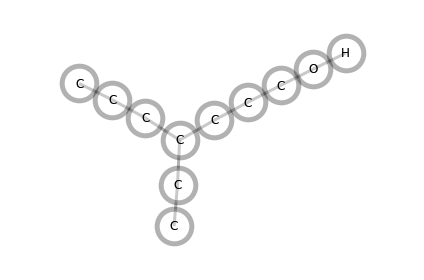

'[O][b1][H][C][C][C][C][b2][C][C][C][C][C]'

In [47]:
def adjust_bond_list_indexes(bond_list):
    old = np.unique( cleaned_bond_list.flatten() ) 
    new = np.arange( old.size )                   
    new_list = np.ones( bond_list.shape ) * -1    
    for i,j in zip(old,new):
        new_list[ bond_list == i ] = j            
    return new_list , old, new


cleaned_bond_list = []
cleaned_atomtypes = []
atoms = np.array(atoms)

for (b0,b1) in bond_list:       
    a0,a1 = atom_names[ [b0,b1] ]
    if "H" in (a0,a1) and "C" in (a0,a1):
        hydrogen = np.array([b0, b1])[ np.array([a0,a1]) == "H" ] 
        print("C + H detected")                                   
        if bond_list[ bond_list == hydrogen ].size == 1:          
            print("continue")                                     
            continue
    print( "keep",b0,b1,"->",a0,"--",a1 )        
    cleaned_bond_list.append( (b0,b1) )
    cleaned_atomtypes.append( (a0,a1) )

cleaned_bond_list = np.array(cleaned_bond_list)
cleaned_atomtypes = np.array(cleaned_atomtypes)    
    
cleaned_atomtypes, cleaned_bond_list

p = np.unique(cleaned_bond_list).astype(int) #vektor nur mit indizes der Bindungen [0,1,2,...]

cleaned_bond_list, old_indexes, new_indexes = adjust_bond_list_indexes(cleaned_bond_list)

cleaned_coordinates = np.array(atoms_xyz)[p]      #Matrix mit Koordinaten der C Atome als zeilen
cleaned_atomtypes   = np.array(atom_names)[p] #Array mit C Atomen

f = open("devel_test.xyz", "w")
f.write(str(len(cleaned_atomtypes))+"\n")
f.write("\n")
for aname,xyz in zip(cleaned_atomtypes,cleaned_coordinates):
    line = "    ".join([aname]+[ str(y) for y in xyz ])
    f.write(line+"\n")
f.close()


graph = graph_from_bonds( cleaned_bond_list )
idx = 0

main_path  = get_longest_path(graph,source=idx)

a,b = get_fun_arrays_set_main( graph, cleaned_bond_list, cleaned_atomtypes, main_path)
b = b.astype(int)

aatom_names = cleaned_atomtypes[ b[ b>=0 ] ]

ms = moleculegraph_syntax().build_string(aatom_names,a)

xx = moleculegraph.molecule(ms)

xx.visualize()
ms

In [48]:
b

array([ 0, -1, 10,  8,  5,  2,  1, -1,  4,  7,  3,  6,  9])

In [46]:
cleaned_atomtypes

array(['O', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H'], dtype='<U1')